In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from datetime import date
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress, t
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.cm
from scipy.misc import imread
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapefile

In [5]:
crimes = pd.read_csv('csvs/Crimes_16.csv')
schools = pd.read_csv('csvs/Schools_1617.csv')

In [6]:
crimes_upd = crimes.copy().drop(['Year', 'Block','ID','Case Number' ,'IUCR', 'Description','X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Updated On', 'Beat', 'Ward', 'District'], axis = 1)
crimes_upd
#crimes

,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,FBI Code,Location
0,05/03/2016 09:00:00 PM,NARCOTICS,SIDEWALK,True,False,26,18,"(41.880658176, -87.731212135)"
1,05/03/2016 09:35:00 PM,THEFT,APARTMENT,False,True,65,06,"(41.77414081, -87.726307093)"
2,05/03/2016 02:45:00 PM,ASSAULT,STREET,False,True,61,08A,"(41.811697721, -87.675214316)"
3,05/03/2016 06:42:00 PM,BATTERY,SIDEWALK,False,True,66,08B,"(41.778661058, -87.68227253)"
4,05/03/2016 03:00:00 PM,ROBBERY,SIDEWALK,False,False,69,03,"(41.766961034, -87.620152116)"
5,05/03/2016 10:02:00 PM,OTHER OFFENSE,STREET,True,False,27,26,"(41.882087429, -87.711041964)"
6,05/03/2016 03:30:00 PM,ASSAULT,SIDEWALK,False,False,26,08A,"(41.874865643, -87.720427367)"
7,05/03/2016 09:09:00 PM,THEFT,APARTMENT,True,False,40,06,"(41.780946398, -87.621995369)"
8,05/03/2016 09:42:00 PM,NARCOTICS,SIDEWALK,True,False,42,18,"(41.784917834, -87.613257846)"
9,05/03/2016 08:42:00 PM,OTHER OFFENSE,STREET,True,True,67,26,"(41.771681167, -87.661575794)"


In [7]:
def def_time(row):
    expression = re.search('(\d+:\d+:\d+) (\w+)', row[0])
    num = int(expression.group(1)[0:2])
    when = expression.group(2)
    if when == 'AM':
        if num == 12:
            return (int(num) - 12)
        else:
            return int(num)
    else:
        if num == 12:
            return int(num)
        else:
            return (int(num) + 12)

        
time = list(map(def_time, crimes_upd.itertuples(index = False)))

crimes_upd['Crime Time'] = time

In [8]:
def def_weekday(row):
    expression = re.search('(\d+)\/(\d+)\/(\d+)', row[0])
    month = int(expression.group(1))
    day = int(expression.group(2))
    year = int(expression.group(3))
    
    day_number = date(year, month, day).weekday()
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day = ""
    for i in range(len(week_days)):
        if day_number == i:
            day = week_days[i]
    
    return day

    
weekdays = list(map(def_weekday, crimes_upd.itertuples(index = False)))
crimes_upd['Crime Day'] = weekdays

In [9]:
crimes_upd['Arrest'] = list(map(lambda row: row[3] == True and 1 or 0, crimes_upd.itertuples(index = False)))
crimes_upd['Domestic'] = list(map(lambda row: row[4] == True and 1 or 0, crimes_upd.itertuples(index = False)))
crimes_upd

,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,FBI Code,Location,Crime Time,Crime Day
0,05/03/2016 09:00:00 PM,NARCOTICS,SIDEWALK,1,0,26,18,"(41.880658176, -87.731212135)",21,Tuesday
1,05/03/2016 09:35:00 PM,THEFT,APARTMENT,0,1,65,06,"(41.77414081, -87.726307093)",21,Tuesday
2,05/03/2016 02:45:00 PM,ASSAULT,STREET,0,1,61,08A,"(41.811697721, -87.675214316)",14,Tuesday
3,05/03/2016 06:42:00 PM,BATTERY,SIDEWALK,0,1,66,08B,"(41.778661058, -87.68227253)",18,Tuesday
4,05/03/2016 03:00:00 PM,ROBBERY,SIDEWALK,0,0,69,03,"(41.766961034, -87.620152116)",15,Tuesday
5,05/03/2016 10:02:00 PM,OTHER OFFENSE,STREET,1,0,27,26,"(41.882087429, -87.711041964)",22,Tuesday
6,05/03/2016 03:30:00 PM,ASSAULT,SIDEWALK,0,0,26,08A,"(41.874865643, -87.720427367)",15,Tuesday
7,05/03/2016 09:09:00 PM,THEFT,APARTMENT,1,0,40,06,"(41.780946398, -87.621995369)",21,Tuesday
8,05/03/2016 09:42:00 PM,NARCOTICS,SIDEWALK,1,0,42,18,"(41.784917834, -87.613257846)",21,Tuesday
9,05/03/2016 08:42:00 PM,OTHER OFFENSE,STREET,1,1,67,26,"(41.771681167, -87.661575794)",20,Tuesday


In [10]:
district = pd.read_csv('csvs/CommAreas.csv')
district = district[['AREA_NUMBE', 'COMMUNITY']]
district = district.sort_values(['AREA_NUMBE'], ascending = True).reset_index(drop=True)
district

,AREA_NUMBE,COMMUNITY
0,1,ROGERS PARK
1,2,WEST RIDGE
2,3,UPTOWN
3,4,LINCOLN SQUARE
4,5,NORTH CENTER
5,6,LAKE VIEW
6,7,LINCOLN PARK
7,8,NEAR NORTH SIDE
8,9,EDISON PARK
9,10,NORWOOD PARK


## Hora em que ocorrem mais crimes

In [11]:
value_count = crimes_upd['Crime Time'].value_counts()
crimes_time = pd.DataFrame(list(zip(value_count.index.tolist(), value_count.tolist())), columns = ['Hour', 'Occurrences'])
crimes_time = crimes_time.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_time

,Hour,Occurrences
0,0,13071
1,1,8085
2,2,7022
3,3,5867
4,4,4633
5,5,4002
6,6,4772
7,7,6697
8,8,9592
9,9,12628


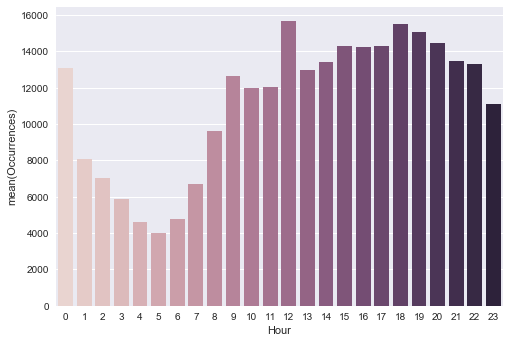

In [12]:
ax = sns.barplot(x = crimes_time['Hour'], y = crimes_time['Occurrences'], palette = sns.cubehelix_palette(24))
plt.show(ax)

## Tipos de crime mais comuns

In [13]:
#print(crimes_upd['Primary Type'].value_counts())

def crimes_type(data, crime_week_or_hour):
    value_size = data.groupby([crime_week_or_hour, 'Primary Type']).size()
    source_list = value_size.copy().index.tolist()
    week_or_hour, kind = zip(*source_list)
    return list(zip(week_or_hour, kind, value_size.tolist()))

crimes_type_hour = pd.DataFrame(crimes_type(crimes_upd, 'Crime Time'), columns = ['Hour', 'Type', 'Occurrences'])
crimes_type_hour = crimes_type_hour.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_type_hour

,Hour,Type,Occurrences
0,0,ARSON,36
1,0,WEAPONS VIOLATION,179
2,0,THEFT,2341
3,0,STALKING,10
4,0,SEX OFFENSE,141
5,0,ROBBERY,633
6,0,PUBLIC PEACE VIOLATION,41
7,0,PROSTITUTION,34
8,0,OTHER OFFENSE,801
9,0,OFFENSE INVOLVING CHILDREN,338


In [14]:
def common_crime(data, init):
    aux = init
    maxi = 0
    maxi2 = 0
    maxi3 = 0
    crime = ""
    crime2 = ""
    crime3 = ""
    hour_crime = []
    
    for row in data.itertuples(index = False):
        if aux != row[0]:
            hour_crime.append((aux, crime, maxi, crime2, maxi2, crime3, maxi3))
            maxi = 0
            maxi2 = 0
            maxi3 = 0
            aux = row[0]
        if row[2] > maxi:
            maxi3 = maxi2
            maxi2 = maxi
            maxi = row[2]
            crime3 = crime2
            crime2 = crime
            crime = row[1]
        elif row[2] > maxi2:
            maxi3 = maxi2
            maxi2 = row[2]
            crime3 = crime2
            crime2 = row[1]
        elif row[2] > maxi3:
            maxi3 = row[2]
            crime3 = row[1]
    hour_crime.append((aux, crime, maxi, crime2, maxi2, crime3, maxi3))
    
    return hour_crime

most_common_crime = pd.DataFrame(common_crime(crimes_type_hour, 0), columns = ['Hour', '1st Crime', '1st Number', '2nd Crime', '2nd Number', '3rd Crime', '3rd Number'])
most_common_crime

,Hour,1st Crime,1st Number,2nd Crime,2nd Number,3rd Crime,3rd Number
0,0,BATTERY,2486,THEFT,2341,CRIMINAL DAMAGE,1764
1,1,BATTERY,2264,THEFT,1445,CRIMINAL DAMAGE,1190
2,2,BATTERY,2087,THEFT,1226,CRIMINAL DAMAGE,1072
3,3,BATTERY,1696,THEFT,957,CRIMINAL DAMAGE,924
4,4,BATTERY,1300,THEFT,778,CRIMINAL DAMAGE,778
5,5,BATTERY,923,THEFT,739,CRIMINAL DAMAGE,618
6,6,THEFT,989,BATTERY,876,CRIMINAL DAMAGE,711
7,7,THEFT,1442,BATTERY,1125,CRIMINAL DAMAGE,827
8,8,THEFT,2154,BATTERY,1538,CRIMINAL DAMAGE,1050
9,9,THEFT,2633,DECEPTIVE PRACTICE,2336,BATTERY,1773


## Horário com mais prisões concretizadas

In [15]:
value_size = crimes_upd.groupby(['Crime Time', 'Arrest']).size()
#print(value_size)
source_list = value_size.copy().index.tolist()
hour, arrest = zip(*source_list)
crimes_arrest_hour = pd.DataFrame(list(zip(hour, arrest, value_size.tolist())), columns = ['Hour', 'Arrest', 'Occurrences'])
crimes_arrest_hour = crimes_arrest_hour.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_arrest_hour

,Hour,Arrest,Occurrences
0,0,0,11035
1,0,1,2036
2,1,0,6542
3,1,1,1543
4,2,0,5782
5,2,1,1240
6,3,0,4900
7,3,1,967
8,4,0,3967
9,4,1,666


In [16]:
def crime_percentage(data):
    skip = False
    num_zero = 0
    num_one = 0
    lista = []
    for row in data.itertuples(index = False):
        if skip:
            if row[1] == 1:
                num_one = row[2]
            else:
                num_zero = row[2]
            lista.append((row[0], num_one/(num_one + num_zero)))
            skip = False
            continue   
        else:
            skip = True
            if row[1] == 1:
                num_one = row[2]
            else:
                num_zero = row[2]
    return lista

data = pd.DataFrame(crime_percentage(crimes_arrest_hour), columns = ['Hour', 'Arrest Percentage'])
data

,Hour,Arrest Percentage
0,0,0.155765
1,1,0.190847
2,2,0.176588
3,3,0.164820
4,4,0.143751
5,5,0.126937
6,6,0.161567
7,7,0.156637
8,8,0.147832
9,9,0.133275


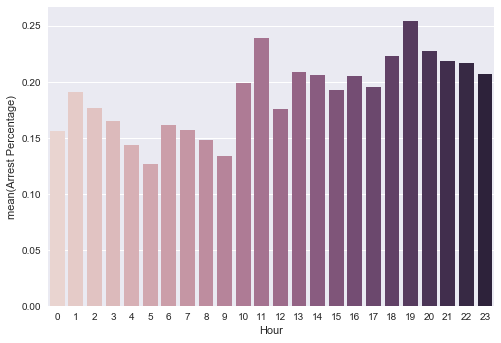

In [17]:
ax = sns.barplot(x = data['Hour'], y = data['Arrest Percentage'], palette = sns.cubehelix_palette(24))
plt.show(ax)

## Horário com mais crimes domésticos

In [18]:
value_size = crimes_upd.groupby(['Crime Time', 'Domestic']).size()
#print(value_size)
source_list = value_size.copy().index.tolist()
hour, arrest = zip(*source_list)
crimes_domestic_hour = pd.DataFrame(list(zip(hour, arrest, value_size.tolist())), columns = ['Hour', 'Domestic', 'Occurrences'])
crimes_domestic_hour = crimes_domestic_hour.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_domestic_hour

,Hour,Domestic,Occurrences
0,0,0,10766
1,0,1,2305
2,1,0,6344
3,1,1,1741
4,2,0,5426
5,2,1,1596
6,3,0,4574
7,3,1,1293
8,4,0,3584
9,4,1,1049


In [19]:
hours_list_domestic = []
occurrences_list_domestic = []
for i in range(len(crimes_domestic_hour)):
    if crimes_domestic_hour['Domestic'][i] == 1:
        hours_list_domestic.append(crimes_domestic_hour['Hour'][i])
        occurrences_list_domestic.append(crimes_domestic_hour['Occurrences'][i])
occurrences_domestic_hour = pd.DataFrame(list(zip(hours_list_domestic, occurrences_list_domestic)), columns = ['Hour', 'Domestic_Occurrences'])
occurrences_domestic_hour

,Hour,Domestic_Occurrences
0,0,2305
1,1,1741
2,2,1596
3,3,1293
4,4,1049
5,5,847
6,6,918
7,7,1194
8,8,1613
9,9,1968


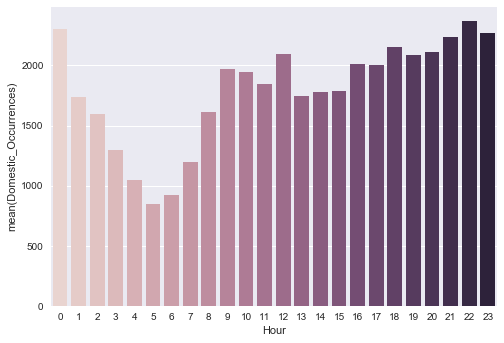

In [20]:
ax = sns.barplot(x = occurrences_domestic_hour['Hour'], y = occurrences_domestic_hour['Domestic_Occurrences'], palette = sns.cubehelix_palette(24))
plt.show(ax)

## Horários com maior porcentagem de crimes domésticos

In [21]:
data_domestic = pd.DataFrame(crime_percentage(crimes_domestic_hour), columns = ['Hour', 'Domestic Percentage'])
data_domestic

,Hour,Domestic Percentage
0,0,0.176345
1,1,0.215337
2,2,0.227286
3,3,0.220385
4,4,0.226419
5,5,0.211644
6,6,0.192372
7,7,0.178289
8,8,0.168161
9,9,0.155844


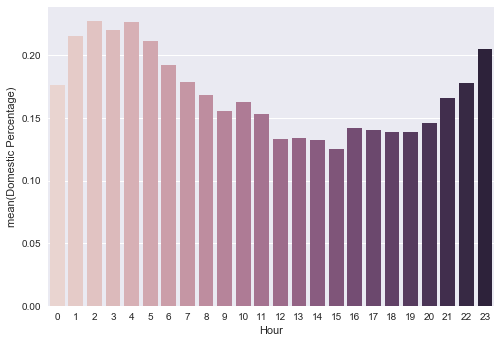

In [22]:
ax = sns.barplot(x = data_domestic['Hour'], y = data_domestic['Domestic Percentage'], palette = sns.cubehelix_palette(24))
plt.show(ax)

## Comparação entre crimes domésticos e não-domésticos

In [23]:
hours_list_not_domestic = []
occurrences_list_not_domestic = []
for i in range(len(crimes_domestic_hour)):
    if crimes_domestic_hour['Domestic'][i] == 0:
        hours_list_not_domestic.append(crimes_domestic_hour['Hour'][i])
        occurrences_list_not_domestic.append(crimes_domestic_hour['Occurrences'][i])
occurrences_not_domestic_hour = pd.DataFrame(list(zip(hours_list_not_domestic, occurrences_list_not_domestic)), columns = ['Hour', 'Non_Domestic_Occurrences'])
occurrences_not_domestic_hour

,Hour,Non_Domestic_Occurrences
0,0,10766
1,1,6344
2,2,5426
3,3,4574
4,4,3584
5,5,3155
6,6,3854
7,7,5503
8,8,7979
9,9,10660


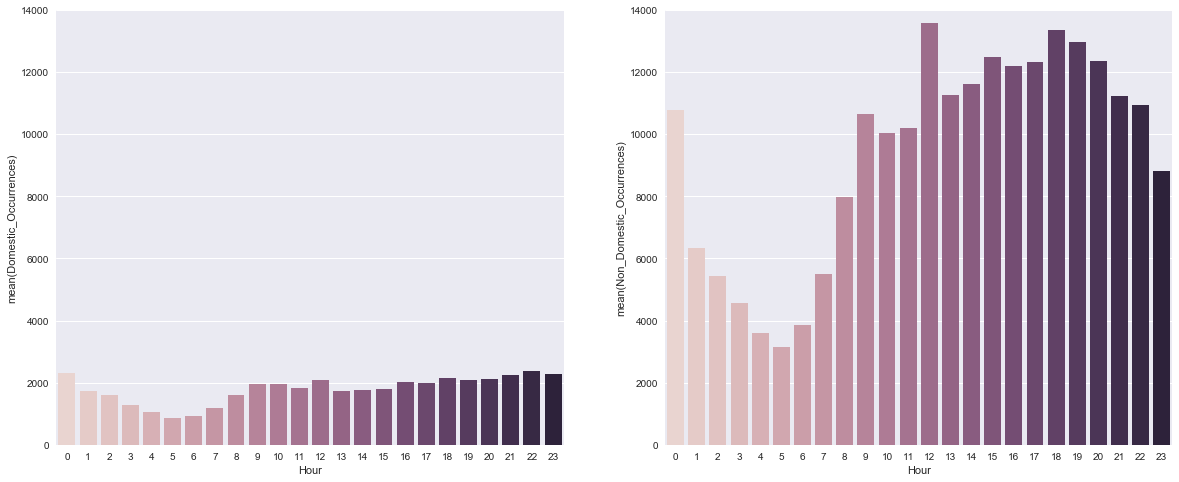

In [24]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
sns.barplot(x = occurrences_domestic_hour['Hour'], y = occurrences_domestic_hour['Domestic_Occurrences'], palette = sns.cubehelix_palette(24), ax=axes[0])
sns.barplot(x = occurrences_not_domestic_hour['Hour'], y = occurrences_not_domestic_hour['Non_Domestic_Occurrences'], palette = sns.cubehelix_palette(24), ax=axes[1])
axes[0].set(ylim=(0, 14000))
axes[1].set(ylim=(0, 14000))
plt.show(fig)

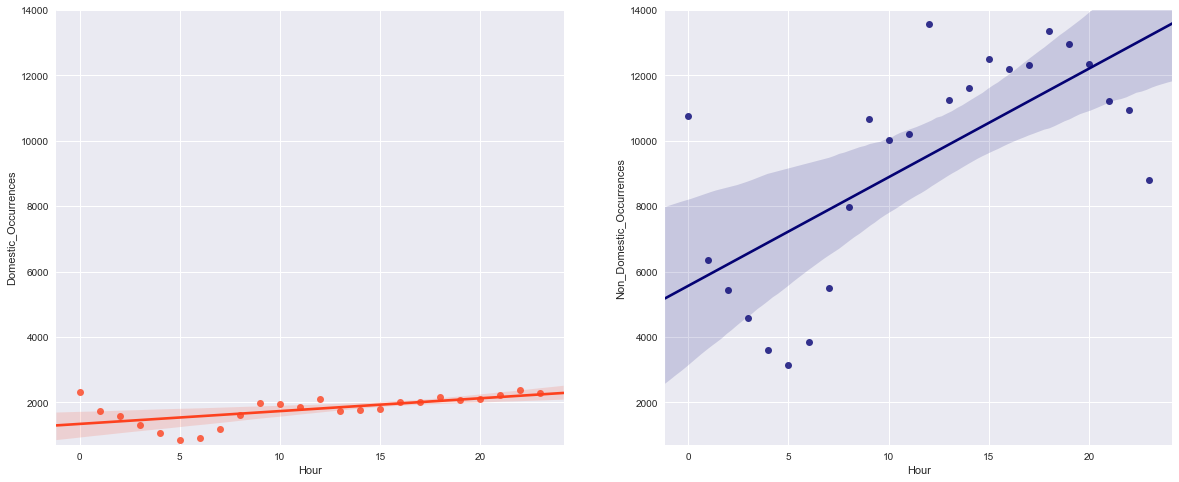

In [25]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
sns.regplot(x = occurrences_domestic_hour['Hour'], y = occurrences_domestic_hour['Domestic_Occurrences'], color=sns.xkcd_rgb["orange red"], ax=axes[0])
sns.regplot(x = occurrences_not_domestic_hour['Hour'], y = occurrences_not_domestic_hour['Non_Domestic_Occurrences'], color=sns.xkcd_rgb["deep blue"], ax=axes[1])
axes[0].set(ylim=(700, 14000))
axes[1].set(ylim=(700, 14000))
plt.show(fig)

In [26]:
model = smf.ols("Domestic_Occurrences ~ Hour",data=occurrences_domestic_hour)
result = model.fit()
pd.concat([result.params,result.bse,result.tvalues,result.pvalues],
          axis=1, keys=['coef','SE','t','p-value'])

,coef,SE,t,p-value
Intercept,1338.726667,138.736420,9.649425,2.301532e-09
Hour,39.223043,10.336018,3.794792,9.935628e-04


In [27]:
model = smf.ols("Non_Domestic_Occurrences ~ Hour",data=occurrences_not_domestic_hour)
result = model.fit()
pd.concat([result.params,result.bse,result.tvalues,result.pvalues],
          axis=1, keys=['coef','SE','t','p-value'])

,coef,SE,t,p-value
Intercept,5563.063333,1004.272922,5.539394,0.000014
Hour,332.175652,74.819453,4.439696,0.000206


# Fazendo as análises iniciais, mas desconsiderando crimes domésticos

## Horários com mais crimes

In [28]:
crimes_nd = crimes_upd.copy()
crimes_nd = crimes_nd.drop(crimes_nd[crimes_nd.Domestic == 1].index)
crimes_nd = crimes_nd.reset_index(drop=True)
crimes_nd

,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,FBI Code,Location,Crime Time,Crime Day
0,05/03/2016 09:00:00 PM,NARCOTICS,SIDEWALK,1,0,26,18,"(41.880658176, -87.731212135)",21,Tuesday
1,05/03/2016 03:00:00 PM,ROBBERY,SIDEWALK,0,0,69,03,"(41.766961034, -87.620152116)",15,Tuesday
2,05/03/2016 10:02:00 PM,OTHER OFFENSE,STREET,1,0,27,26,"(41.882087429, -87.711041964)",22,Tuesday
3,05/03/2016 03:30:00 PM,ASSAULT,SIDEWALK,0,0,26,08A,"(41.874865643, -87.720427367)",15,Tuesday
4,05/03/2016 09:09:00 PM,THEFT,APARTMENT,1,0,40,06,"(41.780946398, -87.621995369)",21,Tuesday
5,05/03/2016 09:42:00 PM,NARCOTICS,SIDEWALK,1,0,42,18,"(41.784917834, -87.613257846)",21,Tuesday
6,05/03/2016 10:15:00 PM,BATTERY,BAR OR TAVERN,0,0,68,04B,"(41.758438955, -87.653943807)",22,Tuesday
7,05/03/2016 09:30:00 AM,CRIMINAL DAMAGE,POLICE FACILITY/VEH PARKING LOT,0,0,29,14,"(41.856790413, -87.708424071)",9,Tuesday
8,05/03/2016 09:15:00 PM,CRIMINAL DAMAGE,STREET,0,0,76,14,"(41.973712278, -87.845720835)",21,Tuesday
9,05/03/2016 07:30:00 AM,DECEPTIVE PRACTICE,OTHER,0,0,17,11,"(41.946619877, -87.782293553)",7,Tuesday


In [29]:
value_countnd = crimes_nd['Crime Time'].value_counts()
crimes_timend = pd.DataFrame(list(zip(value_countnd.index.tolist(), value_countnd.tolist())), columns = ['Hour', 'Occurrences'])
crimes_timend = crimes_timend.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_timend

,Hour,Occurrences
0,0,10766
1,1,6344
2,2,5426
3,3,4574
4,4,3584
5,5,3155
6,6,3854
7,7,5503
8,8,7979
9,9,10660


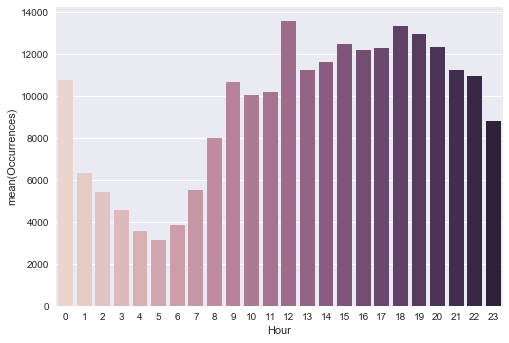

In [43]:
ax = sns.barplot(x = crimes_timend['Hour'], y = crimes_timend['Occurrences'], palette = sns.cubehelix_palette(24))
plt.show(ax)

## Tipos de crimes mais comuns

In [33]:
crimes_type_hournd = pd.DataFrame(crimes_type(crimes_nd, 'Crime Time'), columns = ['Hour', 'Type', 'Occurrences'])
crimes_type_hournd = crimes_type_hournd.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_type_hournd

,Hour,Type,Occurrences
0,0,ARSON,33
1,0,WEAPONS VIOLATION,178
2,0,THEFT,2235
3,0,STALKING,2
4,0,SEX OFFENSE,113
5,0,ROBBERY,629
6,0,PUBLIC PEACE VIOLATION,40
7,0,PROSTITUTION,34
8,0,OTHER OFFENSE,530
9,0,OFFENSE INVOLVING CHILDREN,215


In [34]:
most_common_crimend = pd.DataFrame(common_crime(crimes_type_hournd, 0), columns = ['Hour', '1st Crime', '1st Number', '2nd Crime', '2nd Number', '3rd Crime', '3rd Number'])
most_common_crimend

,Hour,1st Crime,1st Number,2nd Crime,2nd Number,3rd Crime,3rd Number
0,0,THEFT,2235,DECEPTIVE PRACTICE,1676,CRIMINAL DAMAGE,1592
1,1,THEFT,1361,BATTERY,1130,CRIMINAL DAMAGE,1021
2,2,THEFT,1154,BATTERY,1023,CRIMINAL DAMAGE,927
3,3,THEFT,887,BATTERY,835,CRIMINAL DAMAGE,801
4,4,THEFT,720,CRIMINAL DAMAGE,664,BATTERY,602
5,5,THEFT,695,CRIMINAL DAMAGE,529,BATTERY,384
6,6,THEFT,931,CRIMINAL DAMAGE,625,BURGLARY,424
7,7,THEFT,1372,CRIMINAL DAMAGE,744,BURGLARY,698
8,8,THEFT,2063,CRIMINAL DAMAGE,922,DECEPTIVE PRACTICE,920
9,9,THEFT,2500,DECEPTIVE PRACTICE,2313,CRIMINAL DAMAGE,1002


Nota-se que "Battery" perde muita importância nesse novo ranking. Battery é crime de agressão física, que é bem característico do crime doméstico. A frequência de ocorrências de Battery nos crimes domésticos é alta a ponto de colocar o crime como o mais comum em determinadas horas do dia. Mas não é tão comum assim na rua, onde "Theft" domina todos os horários no ranking apenas de crimes não-domésticos.

In [35]:
value_sizend = crimes_nd.groupby(['Crime Time', 'Arrest']).size()
#print(value_size)
source_listnd = value_sizend.copy().index.tolist()
hournd, arrestnd = zip(*source_listnd)
crimes_arrest_hournd = pd.DataFrame(list(zip(hournd, arrestnd, value_sizend.tolist())), columns = ['Hour', 'Arrest', 'Occurrences'])
crimes_arrest_hournd = crimes_arrest_hournd.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_arrest_hournd

,Hour,Arrest,Occurrences
0,0,0,9172
1,0,1,1594
2,1,0,5197
3,1,1,1147
4,2,0,4548
5,2,1,878
6,3,0,3844
7,3,1,730
8,4,0,3126
9,4,1,458


In [36]:
datand = pd.DataFrame(crime_percentage(crimes_arrest_hournd), columns = ['Hour', 'Arrest Percentage'])
datand

,Hour,Arrest Percentage
0,0,0.148059
1,1,0.180801
2,2,0.161813
3,3,0.159598
4,4,0.127790
5,5,0.107132
6,6,0.157499
7,7,0.147738
8,8,0.146886
9,9,0.130957


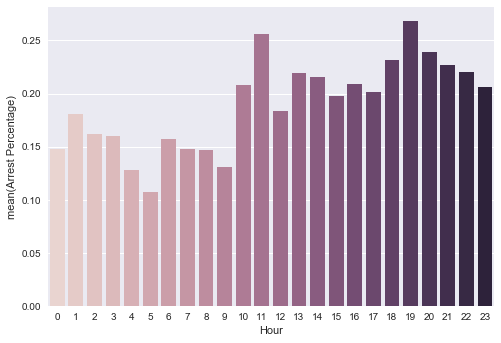

In [37]:
ax = sns.barplot(x = datand['Hour'], y = datand['Arrest Percentage'], palette = sns.cubehelix_palette(24))
plt.show(ax)

A diferença para o primeiro gráfico não é significativa, mas os índices sobem um pouco durante a tarde e a noite e são um pouco menores durante a madrugada e a manhã. Ou seja, podemos ver que retirar os crimes domésticos da análise, muda os resultados, mas pela baixa quantidade de crimes domésticos em comparação com o resto dos crimes essa mudança não é muito significativa

## Regiões Mais Perigosas

### Crimes mais comuns por região/Região com mais prisões/Regiões com mais crimes domésticos/Relação entre escolas e criminalidade

In [38]:
def def_lat(row):
    if pd.isnull(row[7]) == False:
        ycord = float(tuple(row[7].split(', '))[0].split('(')[1])
        return ycord
        
def def_lon(row):
    if pd.isnull(row[7]) == False:
        xcord = float(tuple(row[7].split(', '))[1].split(')')[0]) 
        return xcord

In [39]:
lat = list(map(def_lat, crimes_upd.itertuples(index = False)))
lon = list(map(def_lon, crimes_upd.itertuples(index = False)))
crimes_upd['Lat'] = lat
crimes_upd['Lon'] = lon

In [40]:
crimes_upd.head()

,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,FBI Code,Location,Crime Time,Crime Day,Lat,Lon
0,05/03/2016 09:00:00 PM,NARCOTICS,SIDEWALK,1,0,26,18,"(41.880658176, -87.731212135)",21,Tuesday,41.880658,-87.731212
1,05/03/2016 09:35:00 PM,THEFT,APARTMENT,0,1,65,06,"(41.77414081, -87.726307093)",21,Tuesday,41.774141,-87.726307
2,05/03/2016 02:45:00 PM,ASSAULT,STREET,0,1,61,08A,"(41.811697721, -87.675214316)",14,Tuesday,41.811698,-87.675214
3,05/03/2016 06:42:00 PM,BATTERY,SIDEWALK,0,1,66,08B,"(41.778661058, -87.68227253)",18,Tuesday,41.778661,-87.682273
4,05/03/2016 03:00:00 PM,ROBBERY,SIDEWALK,0,0,69,03,"(41.766961034, -87.620152116)",15,Tuesday,41.766961,-87.620152


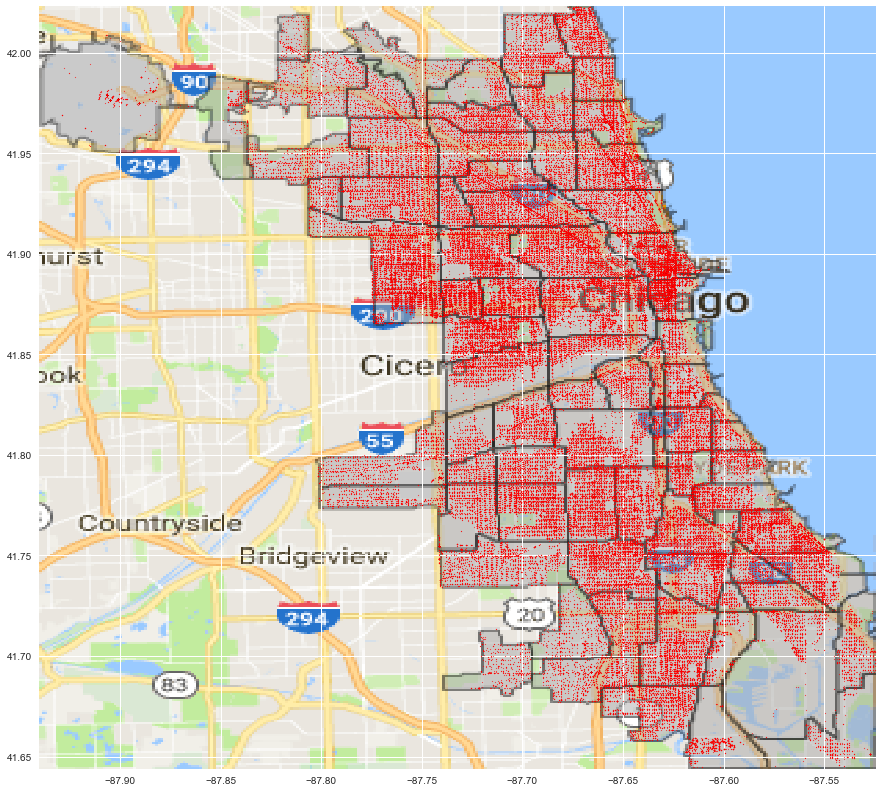

In [41]:
westlimit=-87.940102
southlimit=41.643921
eastlimit=-87.523987
northlimit=42.023022
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(y=crimes_upd['Lat'],x=crimes_upd['Lon'],zorder=1,s=0.8,alpha=0.6,c='red')
img = imread("mapa/CHmap.png")
plt.imshow(img,zorder=0,extent=[westlimit, eastlimit, southlimit, northlimit])
plt.show()

In [44]:
value_count = crimes_upd['Community Area'].value_counts()
crimes_area = pd.DataFrame(list(zip(value_count.index.tolist(), value_count.tolist())), columns = ['Area', 'Occurrences'])
crimes_area = crimes_area.sort_values(['Occurrences'], ascending = False).reset_index(drop = True)
crimes_area

,Area,Occurrences
0,25,16676
1,8,10545
2,28,9444
3,32,9014
4,29,8765
5,24,8227
6,43,8161
7,23,7998
8,71,7582
9,67,6990


In [45]:
crimes_area_name = crimes_area.copy()
areaNames = []
for i in range(len(crimes_area_name)):
    areaNames.append(district['COMMUNITY'][(crimes_area_name['Area'][i]-1)])
crimes_area_name['Area Name'] = areaNames
crimes_area_name

,Area,Occurrences,Area Name
0,25,16676,AUSTIN
1,8,10545,NEAR NORTH SIDE
2,28,9444,NEAR WEST SIDE
3,32,9014,LOOP
4,29,8765,NORTH LAWNDALE
5,24,8227,WEST TOWN
6,43,8161,SOUTH SHORE
7,23,7998,HUMBOLDT PARK
8,71,7582,AUBURN GRESHAM
9,67,6990,WEST ENGLEWOOD


# Comparando com Educação

In [46]:
schools_upd = schools.copy()[['School_ID','Zip', 'Student_Count_Total','School_Latitude','School_Longitude','Overall_Rating']]
schools_upd

,School_ID,Zip,Student_Count_Total,School_Latitude,School_Longitude,Overall_Rating
0,610158,60707,451,41.914151,-87.798721,Level 2
1,610282,60651,399,41.897819,-87.746731,Level 1+
2,609996,60608,500,41.838027,-87.653792,Level 1+
3,400079,60632,619,41.810135,-87.730495,Level 1+
4,610089,60618,523,41.950078,-87.716832,Level 2+
5,609792,60618,1007,41.958220,-87.702151,Level 1+
6,610083,60656,183,41.970125,-87.789630,Inability to Rate
7,609978,60628,355,41.707558,-87.604660,Level 1+
8,610041,60634,1333,41.931762,-87.795604,Level 1+
9,609967,60608,364,41.849215,-87.685668,Level 2+


In [49]:
#sf = shapefile.Reader('mapa/shapeCH.shp')

In [50]:
#school_area = []
#for i in range(len(schools_upd)):
#    flag = 0
#    myPoint = Point(schools_upd['School_Longitude'][i],schools_upd['School_Latitude'][i])
#    for j in range(len(sf.shapes())):
#        myPoly = Polygon(sf.shapes()[j].points)
#        if myPoly.contains(myPoint) == True:
#            flag = 1
#            school_area.append(j)
#            break
#    if flag == 0:
#        school_area.append('')
#schools_upd['Area'] = school_area
#schools_upd.head()

In [51]:
#schools_upd.to_csv('csvs/SchoolsWithArea.csv')

In [52]:
schools_upd = pd.read_csv('csvs/SchoolsWithArea.csv')
schools_upd

,Unnamed: 0,School_ID,Zip,Student_Count_Total,School_Latitude,School_Longitude,Overall_Rating,Area
0,0,610158,60707,451,41.914151,-87.798721,Level 2,25
1,1,610282,60651,399,41.897819,-87.746731,Level 1+,25
2,2,609996,60608,500,41.838027,-87.653792,Level 1+,57
3,3,400079,60632,619,41.810135,-87.730495,Level 1+,53
4,4,610089,60618,523,41.950078,-87.716832,Level 2+,15
5,5,609792,60618,1007,41.958220,-87.702151,Level 1+,15
6,6,610083,60656,183,41.970125,-87.789630,Inability to Rate,35
7,7,609978,60628,355,41.707558,-87.604660,Level 1+,46
8,8,610041,60634,1333,41.931762,-87.795604,Level 1+,17
9,9,609967,60608,364,41.849215,-87.685668,Level 2+,32


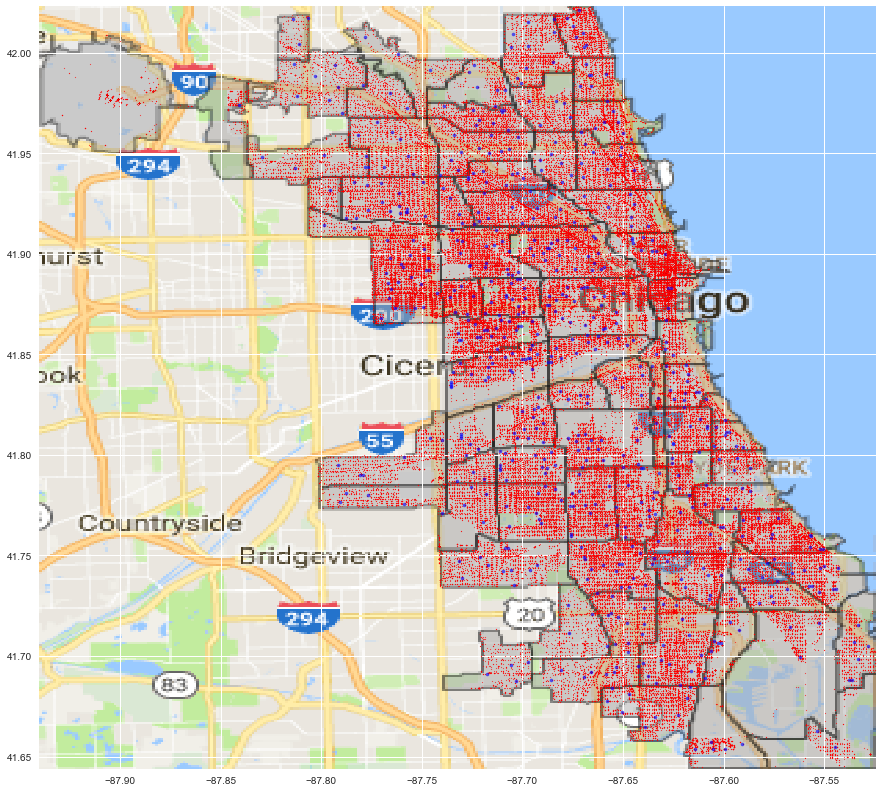

In [53]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(y=crimes_upd['Lat'],x=crimes_upd['Lon'],zorder=1,s=0.8,alpha=0.6,c='red')
plt.scatter(y=schools_upd['School_Latitude'],x=schools_upd['School_Longitude'],zorder=2,s=10,alpha=0.6,c='blue')
img = imread("mapa/CHmap.png")
plt.imshow(img,zorder=0,extent=[westlimit, eastlimit, southlimit, northlimit])
plt.show()

# Número de Escolas

In [54]:
schools_upd['Area'] = schools_upd['Area'].apply(lambda x: x + 1)
value_count = schools_upd['Area'].value_counts()
schools_area = pd.DataFrame(list(zip(value_count.index.tolist(), value_count.tolist())), columns = ['Area', 'Number_Schools'])
#schools_area = schools_area.sort_values(['Number_Schools'], ascending = False).reset_index(drop = True)
#schools_area = schools_area
schools_area = schools_area.sort_values(['Area'], ascending = True).reset_index(drop = True)
schools_area

,Area,Number_Schools
0,1,12
1,2,2
2,3,1
3,4,7
4,5,7
5,6,5
6,7,6
7,8,4
8,9,7
9,10,7


In [55]:
schools_count = []
for i in range(len(crimes_area_name)):
    flag = 0
    for j in range(len(schools_area)):
        if crimes_area_name['Area'][i] == schools_area['Area'][j]:
            flag = 1
            schools_count.append(schools_area['Number_Schools'][j])
    if flag == 0:
        schools_count.append(0)
crimes_area_schools = crimes_area_name.copy()
crimes_area_schools['Schools'] = schools_count
crimes_area_schools

,Area,Occurrences,Area Name,Schools
0,25,16676,AUSTIN,24
1,8,10545,NEAR NORTH SIDE,4
2,28,9444,NEAR WEST SIDE,14
3,32,9014,LOOP,24
4,29,8765,NORTH LAWNDALE,24
5,24,8227,WEST TOWN,17
6,43,8161,SOUTH SHORE,1
7,23,7998,HUMBOLDT PARK,12
8,71,7582,AUBURN GRESHAM,4
9,67,6990,WEST ENGLEWOOD,11


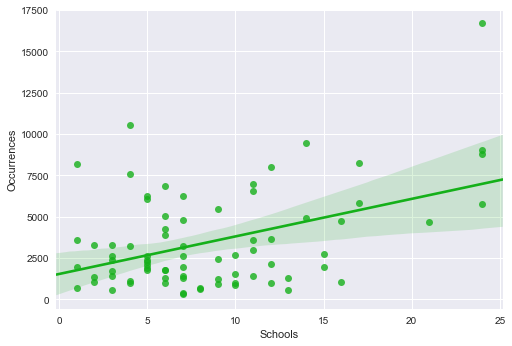

In [56]:
sns.regplot(x = crimes_area_schools['Schools'], y = crimes_area_schools['Occurrences'], color=sns.xkcd_rgb["green"])
plt.show()

Número de escolas na região influencia na quantidade de crimes, mas não do jeito esperado. A conclusão que tivemos foi que por ter mais escolas, possivelmente a região tem um fluxo maior de pessoas, o que possibilita uma maior taxa de crimes. Vamos checar se a qualidade das escolas é relevante

# Qualidade das escolas

# Crimes domésticos

In [57]:
crimes_domestic = crimes_upd.copy()
crimes_domestic = crimes_domestic.drop(crimes_domestic[crimes_domestic.Domestic != 1].index)
crimes_domestic = crimes_domestic.reset_index(drop=True)
crimes_domestic

,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,FBI Code,Location,Crime Time,Crime Day,Lat,Lon
0,05/03/2016 09:35:00 PM,THEFT,APARTMENT,0,1,65,06,"(41.77414081, -87.726307093)",21,Tuesday,41.774141,-87.726307
1,05/03/2016 02:45:00 PM,ASSAULT,STREET,0,1,61,08A,"(41.811697721, -87.675214316)",14,Tuesday,41.811698,-87.675214
2,05/03/2016 06:42:00 PM,BATTERY,SIDEWALK,0,1,66,08B,"(41.778661058, -87.68227253)",18,Tuesday,41.778661,-87.682273
3,05/03/2016 08:42:00 PM,OTHER OFFENSE,STREET,1,1,67,26,"(41.771681167, -87.661575794)",20,Tuesday,41.771681,-87.661576
4,05/03/2016 10:30:00 PM,BATTERY,RESIDENCE,0,1,21,08B,"(41.940175866, -87.725620718)",22,Tuesday,41.940176,-87.725621
5,05/03/2016 09:45:00 PM,THEFT,RESIDENCE PORCH/HALLWAY,0,1,61,06,"(41.796865372, -87.651304707)",21,Tuesday,41.796865,-87.651305
6,05/03/2016 09:40:00 PM,OTHER OFFENSE,HOTEL/MOTEL,0,1,56,26,"(41.798429303, -87.744521435)",21,Tuesday,41.798429,-87.744521
7,05/03/2016 10:45:00 PM,ASSAULT,APARTMENT,0,1,27,04A,"(41.872898796, -87.694388235)",22,Tuesday,41.872899,-87.694388
8,05/03/2016 09:00:00 PM,ASSAULT,RESIDENCE,0,1,69,08A,"(41.757177021, -87.638417211)",21,Tuesday,41.757177,-87.638417
9,05/03/2016 10:10:00 PM,ASSAULT,APARTMENT,1,1,43,04A,"(41.762009273, -87.572502518)",22,Tuesday,41.762009,-87.572503


# Por hora

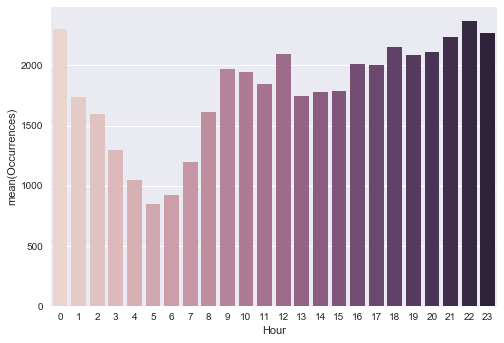

In [58]:
value_count_domestic = crimes_domestic['Crime Time'].value_counts()
crimes_time_domestic = pd.DataFrame(list(zip(value_count_domestic.index.tolist(), value_count_domestic.tolist())), columns = ['Hour', 'Occurrences'])
crimes_time_domestic = crimes_time_domestic.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_time_domestic

ax = sns.barplot(x = crimes_time_domestic['Hour'], y = crimes_time_domestic['Occurrences'], palette = sns.cubehelix_palette(24))
plt.show(ax)

In [69]:
crimes_type_hour_domestic = pd.DataFrame(crimes_type(crimes_domestic, 'Crime Time'), columns = ['Hour', 'Type', 'Occurrences'])
crimes_type_hour_domestic = crimes_type_hour_domestic.sort_values(['Hour'], ascending = True).reset_index(drop = True)
crimes_type_hour_domestic

most_common_crime_domestic_hour = pd.DataFrame(common_crime(crimes_type_hour_domestic, 0), columns = ['Hour', '1st Crime', '1st Number', '2nd Crime', '2nd Number', '3rd Crime', '3rd Number'])
most_common_crime_domestic_hour

,Hour,1st Crime,1st Number,2nd Crime,2nd Number,3rd Crime,3rd Number
0,0,BATTERY,1279,OTHER OFFENSE,271,ASSAULT,189
1,1,BATTERY,1134,CRIMINAL DAMAGE,169,OTHER OFFENSE,159
2,2,BATTERY,1064,CRIMINAL DAMAGE,145,ASSAULT,125
3,3,BATTERY,861,CRIMINAL DAMAGE,123,ASSAULT,96
4,4,BATTERY,698,CRIMINAL DAMAGE,114,OTHER OFFENSE,68
5,5,BATTERY,539,CRIMINAL DAMAGE,89,ASSAULT,71
6,6,BATTERY,536,OTHER OFFENSE,108,CRIMINAL DAMAGE,86
7,7,BATTERY,651,OTHER OFFENSE,174,ASSAULT,137
8,8,BATTERY,840,OTHER OFFENSE,274,ASSAULT,174
9,9,BATTERY,953,OTHER OFFENSE,405,ASSAULT,214


# Por dia da semana

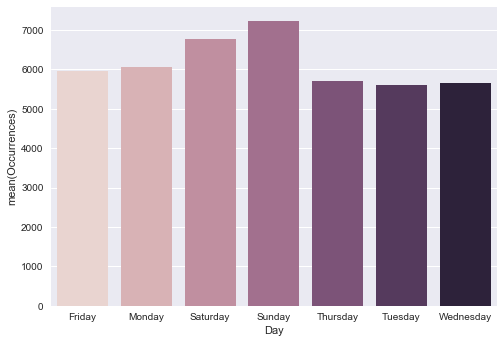

In [70]:
value_count_domestic = crimes_domestic['Crime Day'].value_counts()
crimes_day_domestic = pd.DataFrame(list(zip(value_count_domestic.index.tolist(), value_count_domestic.tolist())), columns = ['Day', 'Occurrences'])
crimes_day_domestic = crimes_day_domestic.sort_values(['Day'], ascending = True).reset_index(drop = True)
crimes_day_domestic

ax = sns.barplot(x = crimes_day_domestic['Day'], y = crimes_day_domestic['Occurrences'], palette = sns.cubehelix_palette(7))
plt.show(ax)

In [71]:
crimes_type_day = pd.DataFrame(crimes_type(crimes_domestic, 'Crime Day'), columns = ['Day', 'Type', 'Occurrences'])
crimes_type_day = crimes_type_day.sort_values(['Day'], ascending = True).reset_index(drop = True)
crimes_type_day

most_common_crime_domestic = pd.DataFrame(common_crime(crimes_type_day, 'Friday'), columns = ['Day', '1st Crime', '1st Number', '2nd Crime', '2nd Number', '3rd Crime', '3rd Number'])
most_common_crime_domestic

,Day,1st Crime,1st Number,2nd Crime,2nd Number,3rd Crime,3rd Number
0,Friday,BATTERY,3298,OTHER OFFENSE,772,ASSAULT,618
1,Monday,BATTERY,3348,OTHER OFFENSE,837,ASSAULT,677
2,Saturday,BATTERY,4010,OTHER OFFENSE,756,ASSAULT,694
3,Sunday,BATTERY,4358,OTHER OFFENSE,769,ASSAULT,737
4,Thursday,BATTERY,3189,OTHER OFFENSE,792,ASSAULT,637
5,Tuesday,BATTERY,3110,OTHER OFFENSE,801,ASSAULT,658
6,Wednesday,BATTERY,3101,OTHER OFFENSE,775,ASSAULT,679
